In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import h5py

In [78]:
power = np.load("dataset\power_data.npz",allow_pickle = True) 
data=power['data'][223].astype(float)

In [216]:
def relation(data,i):
    u=sum(data)/len(data)
    k=1
    expect=[]
    s=0.
    while k+i<len(data):
        j=i
        e=0
        while j<len(data)-k:
            e+=(data[j]-u)*(data[j+k]-u)
            j=j+1
        expect.append(e)
        s+=(float(data[i+k])-float(u))**2
        k=k+1
    #s=sum((data-u)^2)
    r_k=[a/s for a in expect]
    return r_k

In [218]:
r=relation(data,0)

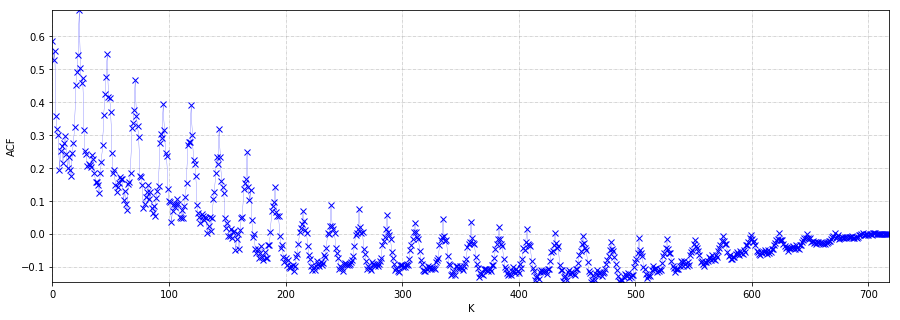

In [239]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.plot(r,'b',marker="x",linewidth=0.2)
plt.autoscale(tight=True)
plt.grid(True, linestyle="-.", linewidth=0.5)
plt.xlabel('K')
plt.ylabel('ACF')
plt.savefig("acf" + ".png")
plt.show()

In [19]:
test_size=144
train_data=data[:-test_size]
test_data=data[-test_size:]
print(len(train_data))
print(len(test_data))

576
144


In [21]:
train_data=torch.FloatTensor(train_data).view(-1)
train_window=12
#滑动窗口
def create_inout_sequences(input_data,tw):
    inout_seq=[]
    L=len(input_data)
    for i in range(L-tw):
        train_seq=input_data[i:i+tw]
        train_label=input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq,train_label))
    return inout_seq

In [22]:
train_inout_seq = create_inout_sequences(train_data, train_window)

In [23]:
class LSTM(nn.Module):
    def __init__(self,input_size=1,hidden_layer_size=50,output_size=1):
        super().__init__()#??
        self.hidden_layer_size=hidden_layer_size
        self.lstm=nn.LSTM(input_size,hidden_layer_size)
        self.linear=nn.Linear(hidden_layer_size,output_size)
        self.hidden_cell=(torch.zeros(1,1,self.hidden_layer_size),
                         torch.zeros(1,1,self.hidden_layer_size))#??
    def forward(self,input_seq):
        lstm_out,self.hidden_cell=self.lstm(input_seq.view(len(input_seq),1,-1),
                                           self.hidden_cell)
        prediction=self.linear(lstm_out.view(len(input_seq),-1))
        return prediction[-1]

In [24]:
model=LSTM()
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.0015)

In [88]:
epochs=150

for i in range(epochs):
    for seq,labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell=(torch.zeros(1,1,model.hidden_layer_size),
                            torch.zeros(1,1,model.hidden_layer_size))
        
        y_pred=model(seq)
        
        single_loss=loss_function(y_pred,labels)
        single_loss.backward()
        optimizer.step()
        
    if i%25==1:
        print("epoch: ",i,"loss: ",single_loss.item())
    loss_r.append(single_loss.item())
print("epoch: ",i,"loss: ",single_loss.item())

epoch:  1 loss:  1.945429903571494e-05
epoch:  26 loss:  0.0003380774287506938
epoch:  49 loss:  5.86587302677799e-05
epoch:  1 loss:  6.633305474679219e-06
epoch:  26 loss:  2.8971151550649665e-05
epoch:  49 loss:  7.693897350691259e-05
epoch:  1 loss:  2.9749855457339436e-05
epoch:  26 loss:  2.225701064162422e-05
epoch:  49 loss:  0.00011677233123918995
epoch:  1 loss:  0.00047026670654304326
epoch:  26 loss:  9.868577762972564e-05
epoch:  49 loss:  2.7445077648735605e-05
epoch:  1 loss:  3.189037670381367e-05
epoch:  26 loss:  0.00017031516472343355
epoch:  49 loss:  1.9352428353158757e-05
epoch:  1 loss:  9.772813791641966e-05
epoch:  26 loss:  9.169019904220477e-06
epoch:  49 loss:  1.9134036847390234e-05
epoch:  1 loss:  7.615329377586022e-05
epoch:  26 loss:  1.0095036486745812e-06
epoch:  49 loss:  1.4435590856010094e-05
epoch:  1 loss:  3.794213989749551e-05
epoch:  26 loss:  4.47726006314042e-06
epoch:  49 loss:  9.174706065095961e-06
epoch:  1 loss:  3.170132185914554e-05
e

In [27]:
fut_pred = 144

test_inputs = train_data[-train_window:].tolist()
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [28]:
predictions = np.array(test_inputs[train_window:] ).reshape(-1, 1)

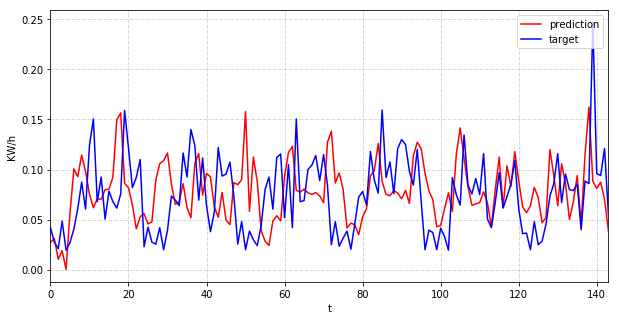

In [42]:
x = np.arange(576, 144, 1)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.grid(True, linestyle="-.", linewidth=0.5)
#plt.title('Load Consumption Prediction')
plt.xlabel('t')
plt.ylabel('KW/h')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(abs(predictions),'r',label="pred")
plt.plot(data[576:],'b',label="real")

plt.legend(["prediction", "target"], loc="upper right")
plt.show()